In [131]:
# Manipulación de datos y numéricos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff # Si la usas para distplots o tablas
import missingno as msno

# Utilidades
from dotenv import load_dotenv
import os
import warnings
import humanize # Ya la tienes para formatear
from scipy import stats # Para análisis estadísticos si es necesario

# Bases de Datos y APIs (si aplica)
import pymongo # Ya la tienes
# import requests # Ya la tienes, si la usas para obtener datos

# (Opcional) Machine Learning si vas a modelar
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error

In [132]:
# Cargar variables de entorno (ej. MAPBOX_TOKEN)
load_dotenv()
MAPBOX_TOKEN = os.getenv('MAPBOX_TOKEN')

if not MAPBOX_TOKEN:
    print("Advertencia: MAPBOX_TOKEN no encontrado. Algunas visualizaciones de mapas podrían no funcionar correctamente.")
    # Podrías asignar un estilo de mapa por defecto que no requiera token si Plotly lo permite
    # o simplemente dejar que falle controladamente más adelante si se intenta usar.

# Configuraciones de visualización
sns.set_style('darkgrid') # O el estilo que prefieras: 'whitegrid', 'seaborn-v0_8-darkgrid'
plt.rcParams['figure.dpi'] = 100 # Mejor resolución para plots de Matplotlib
plt.rcParams['figure.figsize'] = (10, 6) # Tamaño por defecto de figuras Matplotlib

# Ignorar warnings para mantener el notebook limpio (usa con precaución)
warnings.filterwarnings("ignore")

# Configuración para Pandas (opcional, para ver más columnas/filas)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', 100)

In [133]:
def format_tick_humanize(value, tick_number):
    """
    Formatea un valor numérico a una cadena legible por humanos
    (e.g., 1000 -> 1K, 1500000 -> 1.5M).

    Args:
        value (float): El valor numérico a formatear.
        tick_number (int): El número de tick (no se usa en esta implementación,
                           pero a menudo es parte de la firma de los formateadores
                           de matplotlib).
    Returns:
        str: La cadena formateada.
    """
    return humanize.intword(value, format='%.1f') # '%.1f' para un decimal si es M o B

# Podrías añadir más funciones aquí, por ejemplo, para graficar distribuciones,
# o para calcular distancias si haces análisis geoespacial avanzado.

# Análisis del Mercado de Arriendos en Chapinero, Bogotá

**Objetivo Principal:** Analizar las características y los precios de los inmuebles en arriendo en la localidad de Chapinero, Bogotá.

**Preguntas a Responder (Ejemplos):**
* ¿Cuál es la distribución de precios de arriendo en Chapinero?
* ¿Cómo varían los precios según el tipo de inmueble, estrato, área y número de habitaciones/baños?
* ¿Cuáles son los barrios más costosos y más económicos dentro de Chapinero?
* ¿Existe una relación visible entre la cercanía a parques y el precio de los arriendos?
* ¿Cómo se distribuyen geográficamente las ofertas de arriendo y los parques principales?

**Datos Utilizados:**
* Datos de arriendos: [Especificar fuente, ej: Portal Inmobiliario XYZ, extraídos vía Scrapy y almacenados en MongoDB]
* Datos de parques: [Especificar fuente, ej: Datos Abiertos Bogotá, CSV local]

## 2. Carga de Datos

En esta sección, cargaremos los conjuntos de datos necesarios para el análisis.
- **Datos de Arriendos:** Se cargarán desde una base de datos MongoDB.
- **Datos de Parques:** Se cargarán desde un archivo CSV (o la fuente que uses).

In [134]:
# Conexión a MongoDB y carga de datos
client = pymongo.MongoClient(os.getenv('MONGO_URI'))
db = client[os.getenv('MONGO_DATABASE')]
collection = db['scrapy_bogota_apartments_processed']

# Cargamos los datos en un DataFrame
df_arriendos_raw = pd.DataFrame(list(collection.find()))

# Eliminamos columnas innecesarias y filtramos por tipo de operación
df_arriendos_raw = df_arriendos_raw.drop(columns=['_id', 'precio_venta'], axis=1)
df_arriendos_raw = df_arriendos_raw.loc[(df_arriendos_raw['tipo_operacion'] == 'ARRIENDO') & 
                                       (df_arriendos_raw['coords_modified'] == False) & 
                                       (df_arriendos_raw['area'] > 0) &
                                       (df_arriendos_raw['precio_arriendo'] > 0) & 
                                       (df_arriendos_raw['localidad'] == 'SUBA')]

print(f"Dimensiones del DataFrame: {df_arriendos_raw.shape}")
display(df_arriendos_raw.head())
print("\nInformación del DataFrame de Arriendos:")
df_arriendos_raw.info()

# Crear una copia para trabajar y preservar el original
df_arriendos = df_arriendos_raw.copy()

Dimensiones del DataFrame: (836, 48)


,codigo,administracion,antiguedad,area,ascensor,banos,barrio,centro_comercial_cercano,chimenea,closets,...,precio_arriendo,salon_comunal,sector,terraza,timeline,tipo_operacion,tipo_propiedad,url,vigilancia,website
380,11079-M5345562,3500000.0,MAS DE 20 ANOS,400.00,1,5,S.C. NIZA SUBA,CENTRO COMERCIAL BULEVAR,1,None,...,11500000.0,0,CERROS DE SUBA,1,None,ARRIENDO,APARTAMENTO,None,1,metrocuadrado.com
385,851-M3349487,526000.0,ENTRE 5 Y 10 ANOS,124.00,1,4,URB. DEL MONTE,CENTRO COMERCIAL SANTAFE,0,None,...,2972000.0,0,ALTOS DE SUBA Y CERROS DE SAN JORGE,0,None,ARRIENDO,APARTAMENTO,None,1,metrocuadrado.com
428,603-M5721928,NaN,ENTRE 10 Y 20 ANOS,105.00,0,3,BURGOS BRITALIA,CENTRO COMERCIAL PARQUE LA COLINA,1,None,...,5000000.0,0,COLINA Y ALREDEDORES,1,None,ARRIENDO,APARTAMENTO,None,0,metrocuadrado.com
434,2671-M5152629,1500000.0,ENTRE 10 Y 20 ANOS,222.18,0,4,EL CERRITO (LOTE),CENTRO COMERCIAL PARQUE LA COLINA,1,None,...,8000000.0,0,ALTOS DE SUBA Y CERROS DE SAN JORGE,1,None,ARRIENDO,APARTAMENTO,None,1,metrocuadrado.com
520,MC5751916,NaN,MAS DE 20 ANOS,68.00,0,1,NIZA SUR,CENTRO COMERCIAL NIZA,1,None,...,2000000.0,0,NIZA ALHAMBRA,0,None,ARRIENDO,APARTAMENTO,None,0,metrocuadrado.com



Información del DataFrame de Arriendos:
<class 'pandas.core.frame.DataFrame'>
Index: 836 entries, 380 to 18017
Data columns (total 48 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   codigo                        836 non-null    object        
 1   administracion                607 non-null    float64       
 2   antiguedad                    836 non-null    object        
 3   area                          836 non-null    float64       
 4   ascensor                      836 non-null    int64         
 5   banos                         836 non-null    int64         
 6   barrio                        832 non-null    object        
 7   centro_comercial_cercano      836 non-null    object        
 8   chimenea                      836 non-null    int64         
 9   closets                       0 non-null      object        
 10  compañia                      711 non-null    object      

In [135]:
# Asumiendo que tienes un archivo CSV para los parques. Modifica si es otra fuente.
# Si los datos de parques ya están en MongoDB, adapta el código anterior.
FILE_PATH_PARQUES = 'data\external\espacios_para_deporte_bogota\directorio-parques-y-escenarios-2023-datos-abiertos-v1.0.csv' # Reemplaza con la ruta real

try:
    df_parques_raw = pd.read_csv(FILE_PATH_PARQUES)
    print(f"Cargados {len(df_parques_raw)} registros de parques desde CSV.")
    print(f"Dimensiones del DataFrame: {df_parques_raw.shape}")
except FileNotFoundError:
    print(f"Error: Archivo de parques no encontrado en {FILE_PATH_PARQUES}")
    df_parques_raw = pd.DataFrame()
except Exception as e:
    print(f"Error al cargar datos de parques: {e}")
    df_parques_raw = pd.DataFrame()

if not df_parques_raw.empty:
    display(df_parques_raw.head())
    print("\nInformación del DataFrame de Parques:")
    df_parques_raw.info()
else:
    print("No se pudieron cargar los datos de parques.")

# Crear una copia
df_parques = df_parques_raw.copy()

Cargados 210 registros de parques desde CSV.
Dimensiones del DataFrame: (210, 7)


,No.,LOCALIDAD,TIPO DE PARQUE,NOMBRE DEL PARQUE O ESCENARIO,DIRECCIÓN,LATITUD,LONGITUD
0,1,USAQUEN,ZONAL,ALTA BLANCA,Carrera 8A #158-04,4.734315,-74.028784
1,2,USAQUEN,VECINAL,DESARROLLO ESTRELLA DEL NORTE,Calle 159A #19B-60,4.739635,-74.045056
2,3,USAQUEN,VECINAL,DESARROLLO VERBENAL I,Calle 187 #19-22,4.764861,-74.040240
3,4,USAQUEN,METROPOLITANO,EL COUNTRY,Avenida Calle 127 #11D-90,4.704366,-74.038504
4,5,USAQUEN,ZONAL,LA VIDA,Carrera 14A #157-98,4.738300,-74.037140



Información del DataFrame de Parques:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   No.                            210 non-null    int64  
 1   LOCALIDAD                      210 non-null    object 
 2   TIPO DE PARQUE                 210 non-null    object 
 3   NOMBRE DEL PARQUE O ESCENARIO  210 non-null    object 
 4   DIRECCIÓN                      210 non-null    object 
 5   LATITUD                        210 non-null    float64
 6   LONGITUD                       210 non-null    float64
dtypes: float64(2), int64(1), object(4)
memory usage: 11.6+ KB


## 3. Limpieza y Preprocesamiento de Datos (Arriendos)

Antes de analizar, es crucial limpiar y transformar los datos de arriendos para asegurar su calidad y adecuación. Esto incluye:
- Manejo de duplicados.
- Corrección de tipos de datos (numéricos, categóricos, fechas).
- Tratamiento de valores nulos.
- (Opcional) Ingeniería de características.

In [136]:
if not df_arriendos.empty:
    print(f"Número de filas duplicadas: {df_arriendos.duplicated().sum()}")
    df_arriendos.drop_duplicates(inplace=True)
    print(f"Número de filas después de eliminar duplicados: {len(df_arriendos)}")
else:
    print("DataFrame de arriendos vacío, omitiendo manejo de duplicados.")

Número de filas duplicadas: 0


Número de filas después de eliminar duplicados: 836


### 3.1. Corrección de Tipos de Datos y Limpieza Específica

Convertiremos columnas como precio, área, habitaciones, baños y estrato a numéricas. También limpiaremos strings (ej. quitar " COP", "$", "m²").
Columnas como 'barrio', 'tipo_inmueble' serán categóricas.
*(Asume que tienes columnas como 'precio_str', 'area_str', 'habitaciones_str', 'banos_str', 'estrato_str', 'latitud', 'longitud', 'barrio', 'tipo_inmueble')*

In [137]:
if not df_arriendos.empty:
    # Ejemplo para precio (asumiendo que es un string con ' COP' o '$')
    if 'precio_str' in df_arriendos.columns: # Ajusta 'precio_str' al nombre de tu columna
        df_arriendos['precio'] = df_arriendos['precio_str'].astype(str).str.replace(r'[\$\sCOP\.]', '', regex=True).str.replace(',', '.', regex=False)
        df_arriendos['precio'] = pd.to_numeric(df_arriendos['precio'], errors='coerce')

    # Ejemplo para área (asumiendo que es un string con ' m²')
    if 'area_str' in df_arriendos.columns: # Ajusta 'area_str' al nombre de tu columna
        df_arriendos['area'] = df_arriendos['area_str'].astype(str).str.extract(r'(\d+\.?\d*)')[0] # Extrae el primer número
        df_arriendos['area'] = pd.to_numeric(df_arriendos['area'], errors='coerce')

    # Para columnas que ya deberían ser numéricas pero pueden ser object
    cols_to_numeric = ['habitaciones', 'banos', 'estrato', 'garajes', 'administracion'] # Ajusta a tus nombres
    for col in cols_to_numeric:
        if col in df_arriendos.columns:
            df_arriendos[col] = pd.to_numeric(df_arriendos[col], errors='coerce')

    # Para coordenadas (si no son ya numéricas)
    coords_cols = ['latitud', 'longitud'] # Ajusta a tus nombres
    for col in coords_cols:
        if col in df_arriendos.columns:
            df_arriendos[col] = pd.to_numeric(df_arriendos[col], errors='coerce')
            # Considera un rango válido para Bogotá si quieres filtrar datos erróneos
            # Ejemplo para latitud en Bogotá (aprox 3.7 a 4.9)
            # df_arriendos = df_arriendos[df_arriendos[col].between(3.7, 4.9)] # para latitud

    # Columnas categóricas
    cols_to_categorical = ['barrio', 'tipo_inmueble', 'estado_conservacion'] # Ajusta a tus nombres
    for col in cols_to_categorical:
        if col in df_arriendos.columns:
            df_arriendos[col] = df_arriendos[col].astype('category')

    print("Tipos de datos después de la conversión:")
    df_arriendos.info()
    display(df_arriendos.sample(5)) # Muestra aleatoria para verificar
else:
    print("DataFrame de arriendos vacío, omitiendo corrección de tipos.")

Tipos de datos después de la conversión:
<class 'pandas.core.frame.DataFrame'>
Index: 836 entries, 380 to 18017
Data columns (total 48 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   codigo                        836 non-null    object        
 1   administracion                607 non-null    float64       
 2   antiguedad                    836 non-null    object        
 3   area                          836 non-null    float64       
 4   ascensor                      836 non-null    int64         
 5   banos                         836 non-null    int64         
 6   barrio                        832 non-null    category      
 7   centro_comercial_cercano      836 non-null    object        
 8   chimenea                      836 non-null    int64         
 9   closets                       0 non-null      object        
 10  compañia                      711 non-null    object      

,codigo,administracion,antiguedad,area,ascensor,banos,barrio,centro_comercial_cercano,chimenea,closets,...,precio_arriendo,salon_comunal,sector,terraza,timeline,tipo_operacion,tipo_propiedad,url,vigilancia,website
14779,MC5746586,NaN,ENTRE 10 Y 20 ANOS,73.0,1,2,GILMAR II,CENTRO COMERCIAL PARQUE LA COLINA,0,None,...,2500000.0,0,COLINA Y ALREDEDORES,0,None,ARRIENDO,APARTAMENTO,None,1,metrocuadrado.com
16088,MC5785884,NaN,ENTRE 0 Y 5 ANOS,101.7,1,3,URB. VERSALLES,CENTRO COMERCIAL PARQUE LA COLINA,1,None,...,4000000.0,0,COLINA Y ALREDEDORES,0,None,ARRIENDO,APARTAMENTO,None,1,metrocuadrado.com
11893,164-M5741729,NaN,REMODELADO,32.0,0,1,URB. PLAZA BAVIERA,CENTRO COMERCIAL SANTAFE,0,None,...,1500000.0,0,170 Y ALREDORES,0,None,ARRIENDO,APARTAMENTO,None,1,metrocuadrado.com
14126,13436-M5763441,267200.0,MAS DE 20 ANOS,61.0,1,2,MIRANDELA,CENTRO COMERCIAL SANTAFE,0,None,...,1800000.0,0,170 Y ALREDORES,0,None,ARRIENDO,APARTAMENTO,None,1,metrocuadrado.com
16996,246-M5753818,296000.0,MAS DE 20 ANOS,40.0,1,1,LA ALHAMBRA SECTOR SUR,CENTRO COMERCIAL ISERRA 100,1,None,...,1875000.0,0,NIZA ALHAMBRA,1,None,ARRIENDO,APARTAMENTO,None,1,metrocuadrado.com


### 3.2. Manejo de Valores Nulos

Visualizaremos los valores nulos y decidiremos una estrategia para tratarlos (imputación o eliminación).

Porcentaje de valores nulos por columna:
direccion         100.000000
closets           100.000000
url               100.000000
timeline          100.000000
piso               38.875598
administracion     27.392344
compañia           14.952153
midinmueble        14.234450
barrio              0.478469
dtype: float64


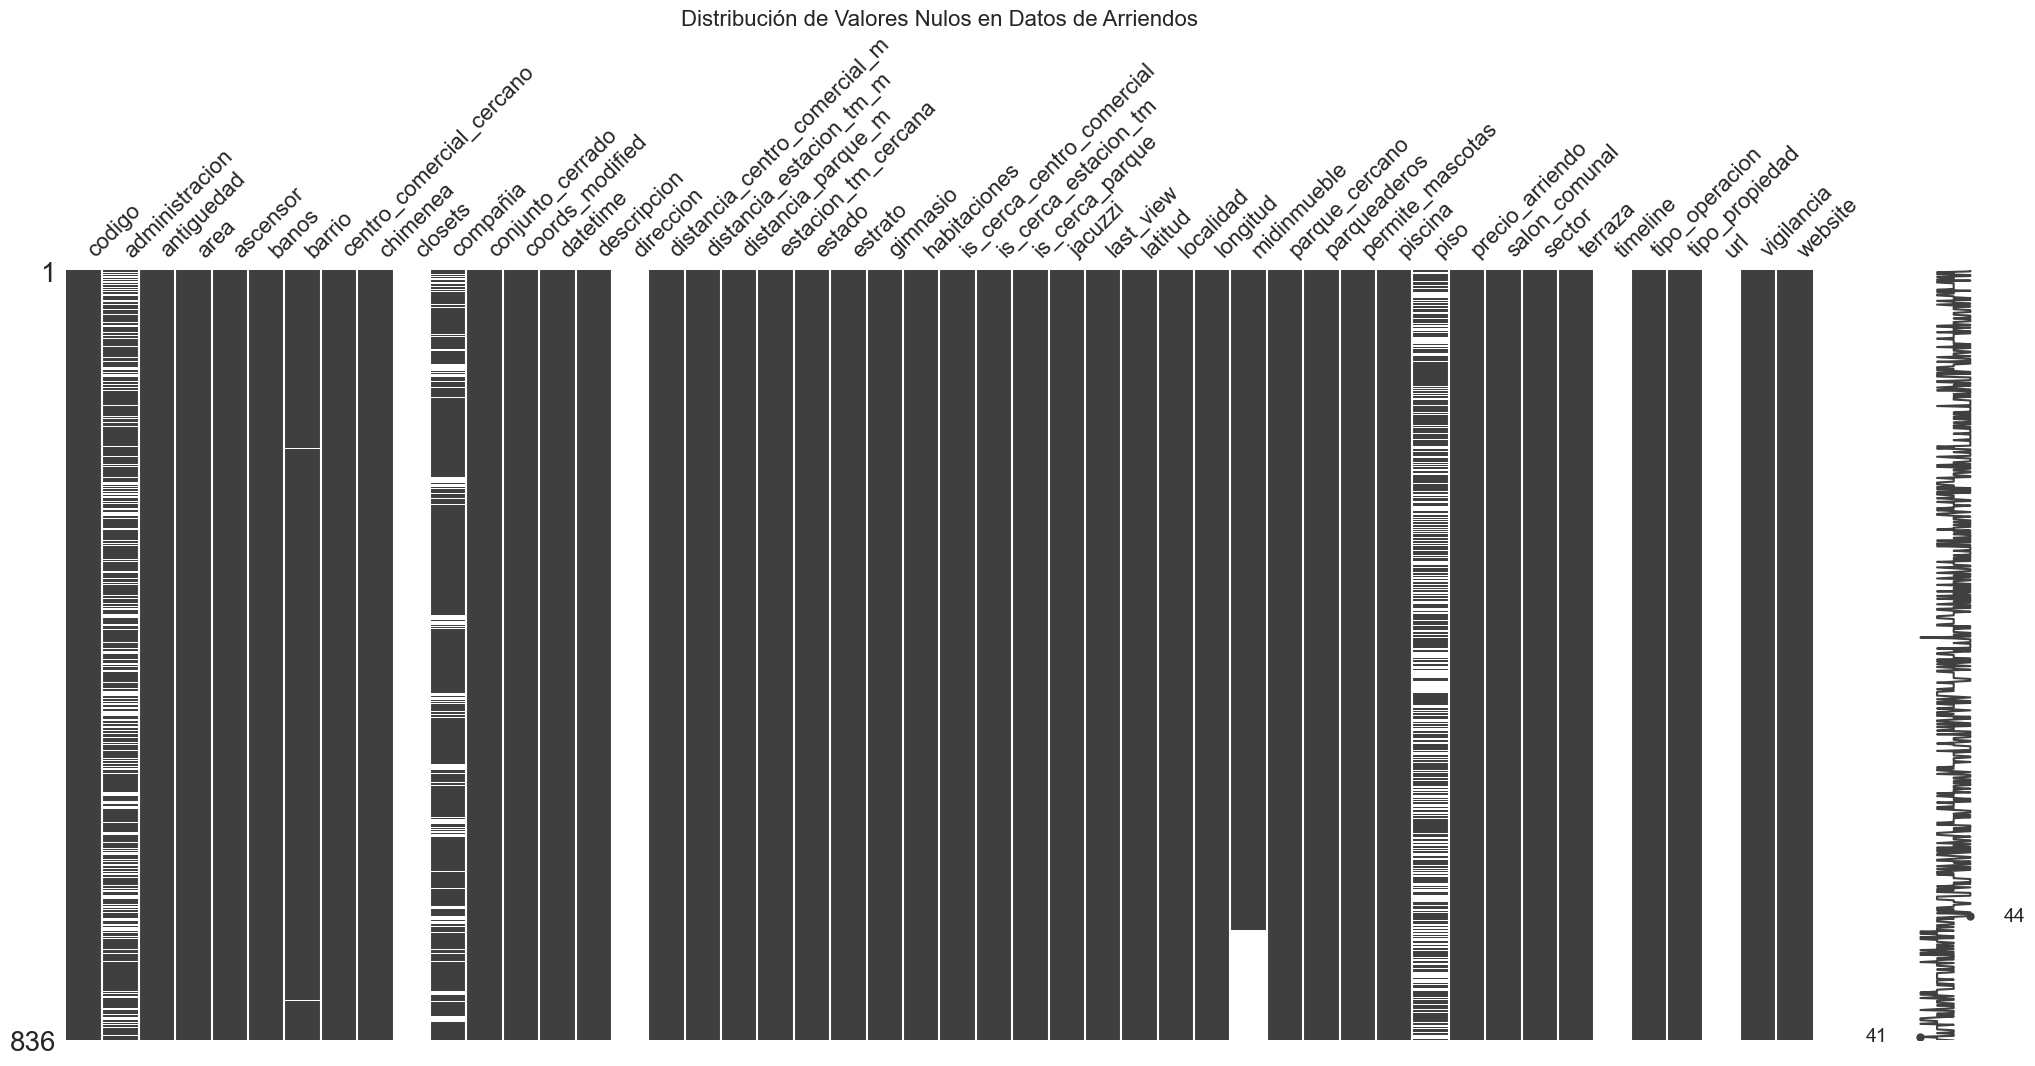

Nulos en 'administracion' imputados con 0.
Nulos en 'barrio' imputados con la moda (LOS OTONOS).

Porcentaje de valores nulos después de la imputación:
direccion      100.000000
closets        100.000000
url            100.000000
timeline       100.000000
piso            38.875598
compañia        14.952153
midinmueble     14.234450
dtype: float64


In [138]:
if not df_arriendos.empty:
    print("Porcentaje de valores nulos por columna:")
    null_percentage = (df_arriendos.isnull().sum() / len(df_arriendos) * 100).sort_values(ascending=False)
    print(null_percentage[null_percentage > 0])

    msno.matrix(df_arriendos)
    plt.title('Distribución de Valores Nulos en Datos de Arriendos', fontsize=16)
    plt.show()

    # Estrategia de imputación (EJEMPLOS, ¡ajústalos!):
    # Para 'precio' y 'area', si hay pocos nulos y son cruciales, podríamos eliminar las filas.
    # O imputar si tiene sentido (ej. precio basado en características similares, pero es complejo).
    # df_arriendos.dropna(subset=['precio', 'area'], inplace=True)

    # Para 'habitaciones', 'banos', 'estrato', 'garajes': imputar con la mediana o moda.
    for col in ['habitaciones', 'banos', 'estrato', 'garajes']:
        if col in df_arriendos.columns and df_arriendos[col].isnull().any():
            mediana_val = df_arriendos[col].median()
            df_arriendos[col].fillna(mediana_val, inplace=True)
            print(f"Nulos en '{col}' imputados con la mediana ({mediana_val}).")

    # Para 'administracion': a menudo es 0 si no se especifica o está incluida.
    if 'administracion' in df_arriendos.columns and df_arriendos['administracion'].isnull().any():
        df_arriendos['administracion'].fillna(0, inplace=True)
        print("Nulos en 'administracion' imputados con 0.")

    # Para 'barrio' o 'tipo_inmueble' (categóricos): imputar con la moda o "Desconocido".
    for col in ['barrio', 'tipo_inmueble']:
        if col in df_arriendos.columns and df_arriendos[col].isnull().any():
            moda_val = df_arriendos[col].mode()[0]
            df_arriendos[col].fillna(moda_val, inplace=True) # O 'Desconocido'
            print(f"Nulos en '{col}' imputados con la moda ({moda_val}).")

    # Re-verificar nulos
    print("\nPorcentaje de valores nulos después de la imputación:")
    null_percentage_after = (df_arriendos.isnull().sum() / len(df_arriendos) * 100).sort_values(ascending=False)
    print(null_percentage_after[null_percentage_after > 0])
    if null_percentage_after.sum() == 0:
        print("¡Todos los valores nulos han sido tratados!")
else:
    print("DataFrame de arriendos vacío, omitiendo manejo de nulos.")

### 3.3. Ingeniería de Características (Opcional)

Crear nuevas variables a partir de las existentes puede mejorar el análisis.

In [139]:
if not df_arriendos.empty:
    # Precio por metro cuadrado
    if 'precio' in df_arriendos.columns and 'area' in df_arriendos.columns:
        # Evitar división por cero o áreas muy pequeñas si no se filtraron antes
        df_arriendos['precio_m2'] = np.where(df_arriendos['area'] > 0, df_arriendos['precio'] / df_arriendos['area'], np.nan)

    # Total baños (si tienes 'banos_social' y 'banos_privados')
    # df_arriendos['banos_totales'] = df_arriendos['banos_social'] + df_arriendos['banos_privados']

    # Antigüedad (si tienes 'ano_construccion')
    # from datetime import datetime
    # current_year = datetime.now().year
    # if 'ano_construccion' in df_arriendos.columns:
    #     df_arriendos['antiguedad'] = current_year - df_arriendos['ano_construccion']

    print("Nuevas características creadas.")
    display(df_arriendos.sample(3))
else:
    print("DataFrame de arriendos vacío, omitiendo ingeniería de características.")

Nuevas características creadas.


,codigo,administracion,antiguedad,area,ascensor,banos,barrio,centro_comercial_cercano,chimenea,closets,...,precio_arriendo,salon_comunal,sector,terraza,timeline,tipo_operacion,tipo_propiedad,url,vigilancia,website
14206,10307-M5631630,1013000.0,ENTRE 5 Y 10 ANOS,142.0,1,5,TORREMOLINOS_,CENTRO COMERCIAL BIMA,1,None,...,5687000.0,0,GUAYMARAL,0,None,ARRIENDO,APARTAMENTO,None,1,metrocuadrado.com
10568,4058-M5543888,250000.0,ENTRE 0 Y 5 ANOS,45.0,1,2,LOS OTONOS,CENTRO COMERCIAL SANTAFE,0,None,...,1450000.0,0,GUAYMARAL,0,None,ARRIENDO,APARTAMENTO,None,1,metrocuadrado.com
16762,898-M3447482,376000.0,ENTRE 10 Y 20 ANOS,80.0,1,2,LA VICTORIA NORTE,CENTRO COMERCIAL MAZUREN,0,None,...,1924000.0,0,COLINA Y ALREDEDORES,1,None,ARRIENDO,APARTAMENTO,None,1,metrocuadrado.com


### 3.4. DataFrame de Arriendos Limpio

Veamos un resumen estadístico y la información del DataFrame limpio.

In [140]:
if not df_arriendos.empty:
    print("Información del DataFrame de arriendos limpio:")
    df_arriendos.info()
    print("\nEstadísticas descriptivas de variables numéricas:")
    display(df_arriendos.describe(percentiles=[.01, .05, .25, .5, .75, .95, .99]).applymap(lambda x: f"{x:,.0f}" if isinstance(x, (int, float)) else x))
    print("\nEstadísticas descriptivas de variables categóricas:")
    display(df_arriendos.describe(include='category'))
else:
    print("DataFrame de arriendos vacío.")

Información del DataFrame de arriendos limpio:
<class 'pandas.core.frame.DataFrame'>
Index: 836 entries, 380 to 18017
Data columns (total 48 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   codigo                        836 non-null    object        
 1   administracion                836 non-null    float64       
 2   antiguedad                    836 non-null    object        
 3   area                          836 non-null    float64       
 4   ascensor                      836 non-null    int64         
 5   banos                         836 non-null    int64         
 6   barrio                        836 non-null    category      
 7   centro_comercial_cercano      836 non-null    object        
 8   chimenea                      836 non-null    int64         
 9   closets                       0 non-null      object        
 10  compañia                      711 non-null    object

,administracion,area,ascensor,banos,chimenea,conjunto_cerrado,coords_modified,datetime,distancia_centro_comercial_m,distancia_estacion_tm_m,...,latitud,longitud,parqueaderos,permite_mascotas,piscina,piso,precio_arriendo,salon_comunal,terraza,vigilancia
count,836,836,836,836,836,836,836,836,836,836,...,836,836,836,836,836,511,836,836,836,836
mean,"433,531",98,1,2,0,0,0,2025-06-03 08:46:10.477155328,"1,283",904,...,5,-74,1,0,0,8,"7,335,833",0,0,1
min,0,18,0,1,0,0,0,2025-06-02 21:36:03.009000,87,10,...,5,-74,0,0,0,1,"700,000",0,0,0
1%,0,26,0,1,0,0,0,2025-06-02 21:44:40.255849984,134,97,...,5,-74,0,0,0,1,"800,000",0,0,0
5%,0,35,0,1,0,0,0,2025-06-02 21:53:58.840000,368,190,...,5,-74,0,0,0,1,"1,000,000",0,0,0
25%,0,50,0,1,0,0,0,2025-06-03 05:05:18.398000128,800,424,...,5,-74,0,0,0,2,"1,549,400",0,0,1
50%,"284,000",70,1,2,0,0,0,2025-06-03 08:21:16.832999936,"1,125",788,...,5,-74,1,0,0,4,"2,319,000",0,0,1
75%,"600,000",108,1,3,0,1,0,2025-06-03 11:53:24.342499840,"1,587","1,258",...,5,-74,2,0,0,6,"4,000,000",0,1,1
95%,"1,562,500",270,1,5,1,1,0,2025-06-03 19:30:48.831750144,"3,079","2,013",...,5,-74,3,1,1,15,"9,009,000",0,1,1
99%,"2,430,000",487,1,5,1,1,0,2025-06-03 19:48:19.514099968,"3,335","2,669",...,5,-74,4,1,1,18,"17,650,000",0,1,1



Estadísticas descriptivas de variables categóricas:


,barrio
count,836
unique,217
top,LOS OTONOS
freq,54


## 4. Limpieza y Preprocesamiento de Datos (Parques)

Limpiaremos los datos de parques, enfocándonos en las columnas necesarias para el análisis geoespacial (nombre, tipo, latitud, longitud).
*(Asume que tu df_parques tiene columnas como 'NOMBRE DEL PARQUE O ESCENARIO', 'TIPO DE PARQUE', 'LATITUD', 'LONGITUD')*

In [141]:
if not df_parques.empty:
    # Renombrar columnas para consistencia y facilidad (opcional)
    column_mapping_parques = {
        'NOMBRE DEL PARQUE O ESCENARIO': 'nombre_parque',
        'TIPO DE PARQUE': 'tipo_parque',
        'LATITUD': 'latitud_parque', # Asegúrate que estos sean los nombres correctos
        'LONGITUD': 'longitud_parque' # y que sean numéricos.
    }
    df_parques.rename(columns=column_mapping_parques, inplace=True)

    # Seleccionar columnas relevantes
    cols_relevantes_parques = ['nombre_parque', 'tipo_parque', 'latitud_parque', 'longitud_parque'] # Ajusta
    df_parques = df_parques[[col for col in cols_relevantes_parques if col in df_parques.columns]]

    # Verificar nulos en columnas clave de parques
    print("Nulos en datos de parques (columnas seleccionadas):")
    print(df_parques.isnull().sum())
    # Estrategia: Eliminar parques sin coordenadas o nombre si son pocos
    df_parques.dropna(subset=['nombre_parque', 'latitud_parque', 'longitud_parque'], inplace=True)

    # Convertir coordenadas a numérico si no lo son ya
    for col in ['latitud_parque', 'longitud_parque']:
        if col in df_parques.columns:
            df_parques[col] = pd.to_numeric(df_parques[col], errors='coerce')
    df_parques.dropna(subset=['latitud_parque', 'longitud_parque'], inplace=True) # Eliminar si la conversión falló

    print(f"\nDimensiones del DataFrame de parques después de la limpieza: {df_parques.shape}")
    display(df_parques.head())
    df_parques.info()
else:
    print("DataFrame de parques vacío.")

Nulos en datos de parques (columnas seleccionadas):
nombre_parque      0
tipo_parque        0
latitud_parque     0
longitud_parque    0
dtype: int64

Dimensiones del DataFrame de parques después de la limpieza: (210, 4)


,nombre_parque,tipo_parque,latitud_parque,longitud_parque
0,ALTA BLANCA,ZONAL,4.734315,-74.028784
1,DESARROLLO ESTRELLA DEL NORTE,VECINAL,4.739635,-74.045056
2,DESARROLLO VERBENAL I,VECINAL,4.764861,-74.040240
3,EL COUNTRY,METROPOLITANO,4.704366,-74.038504
4,LA VIDA,ZONAL,4.738300,-74.037140


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   nombre_parque    210 non-null    object 
 1   tipo_parque      210 non-null    object 
 2   latitud_parque   210 non-null    float64
 3   longitud_parque  210 non-null    float64
dtypes: float64(2), object(2)
memory usage: 6.7+ KB


## 5. Análisis Exploratorio de Datos (EDA) - Univariado

Analizaremos la distribución de cada variable individualmente para entender sus características.

### 5.1. Variable Objetivo: Precio del Arriendo (`precio`)


Se analizarán 807 registros después de filtrar precios extremos (1% y 97%).


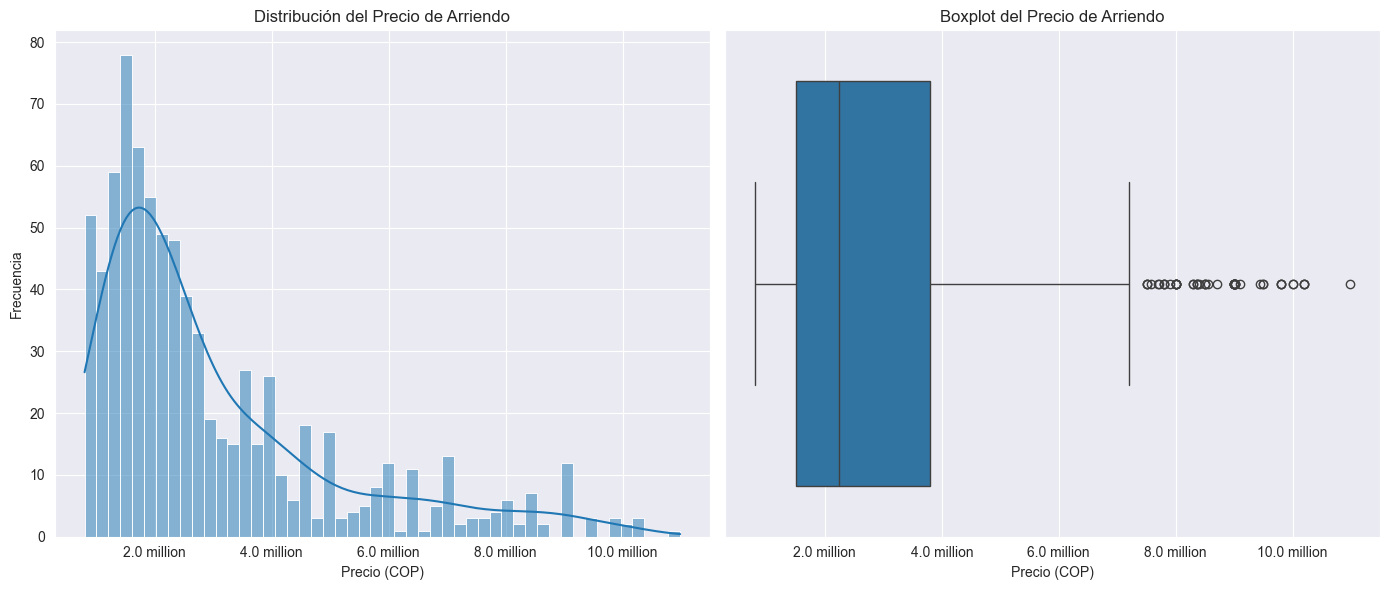

Estadísticas descriptivas del precio:


count           807
mean      3,009,851
std       2,095,897
min         800,000
1%          800,000
5%        1,000,000
10%       1,200,000
25%       1,502,000
50%       2,250,000
75%       3,800,000
90%       6,332,000
95%       7,970,000
99%       9,782,000
max      10,983,000
Name: precio_arriendo, dtype: object

In [142]:
if not df_arriendos.empty and 'precio_arriendo' in df_arriendos.columns:
    # Opcional: Identificar y quizás filtrar outliers extremos si afectan mucho las visualizaciones
    q_low = df_arriendos['precio_arriendo'].quantile(0.01)
    q_high = df_arriendos['precio_arriendo'].quantile(0.97)
    df_arriendos_filtrado_precio = df_arriendos[(df_arriendos['precio_arriendo'] >= q_low) & (df_arriendos['precio_arriendo'] <= q_high)]
    print(f"\nSe analizarán {len(df_arriendos_filtrado_precio)} registros después de filtrar precios extremos (1% y 97%).")
    
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.histplot(df_arriendos_filtrado_precio['precio_arriendo'], kde=True, bins=50)
    plt.title('Distribución del Precio de Arriendo')
    plt.xlabel('Precio (COP)')
    plt.ylabel('Frecuencia')
    # Usar tu función para formatear el eje x
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_tick_humanize))


    plt.subplot(1, 2, 2)
    sns.boxplot(x=df_arriendos_filtrado_precio['precio_arriendo'])
    plt.title('Boxplot del Precio de Arriendo')
    plt.xlabel('Precio (COP)')
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_tick_humanize))

    plt.tight_layout()
    plt.show()

    print("Estadísticas descriptivas del precio:")
    display(df_arriendos_filtrado_precio['precio_arriendo'].describe(percentiles=[.01, .05, .1, .25, .5, .75, .9, .95, .99]).apply(lambda x: f"{x:,.0f}"))

    df_arriendos = df_arriendos_filtrado_precio
else:
    print("Columna 'precio' no disponible para análisis.")

### 5.2. Área del Inmueble (`area`)

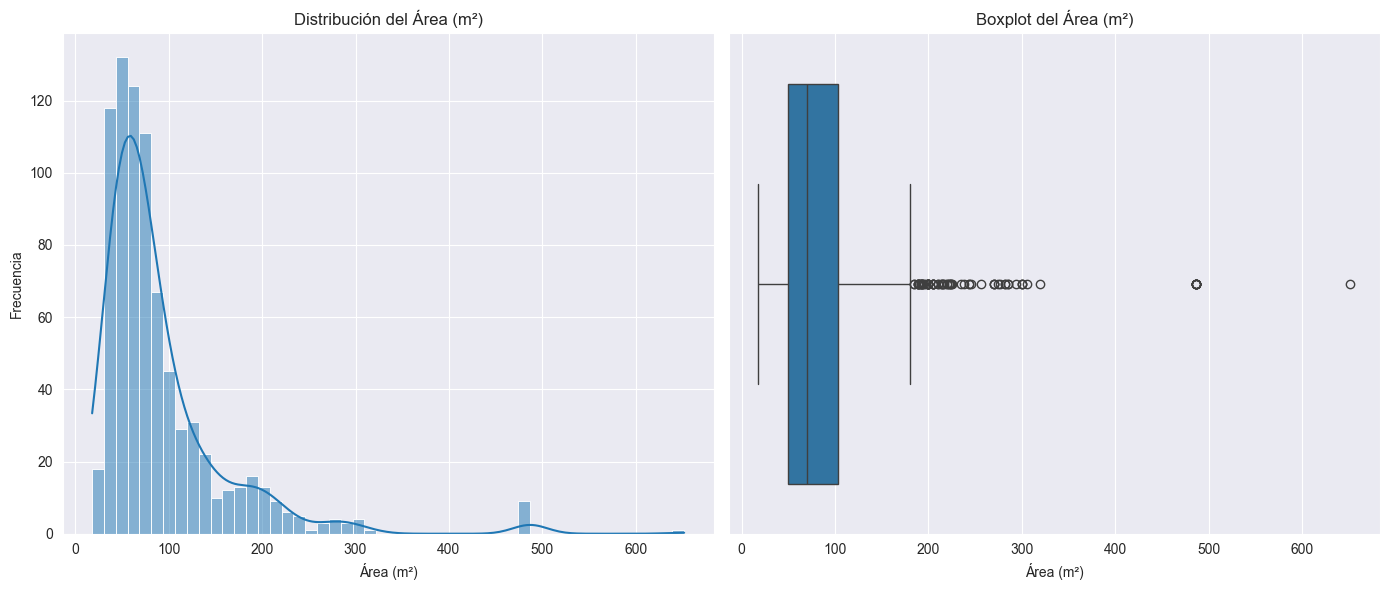

Estadísticas descriptivas del área:


count    807.0
mean      91.4
std       71.2
min       18.0
1%        25.1
5%        35.0
10%       40.0
25%       50.0
50%       70.0
75%      103.8
90%      177.4
95%      215.7
99%      487.0
max      651.9
Name: area, dtype: object

In [143]:
if not df_arriendos.empty and 'area' in df_arriendos.columns:
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.histplot(df_arriendos['area'], kde=True, bins=50)
    plt.title('Distribución del Área (m²)')
    plt.xlabel('Área (m²)')
    plt.ylabel('Frecuencia')

    plt.subplot(1, 2, 2)
    sns.boxplot(x=df_arriendos['area'])
    plt.title('Boxplot del Área (m²)')
    plt.xlabel('Área (m²)')

    plt.tight_layout()
    plt.show()

    print("Estadísticas descriptivas del área:")
    display(df_arriendos['area'].describe(percentiles=[.01, .05, .1, .25, .5, .75, .9, .95, .99]).apply(lambda x: f"{x:,.1f}"))
else:
    print("Columna 'area' no disponible para análisis.")

### 5.3. Variables Categóricas y Discretas
Analizaremos la frecuencia de categorías para 'estrato', 'tipo_inmueble', 'habitaciones', 'banos' y los principales 'barrios'.

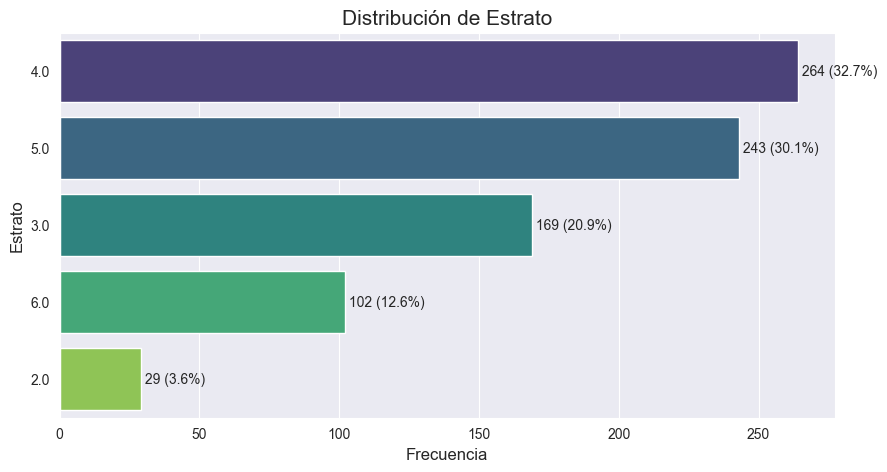

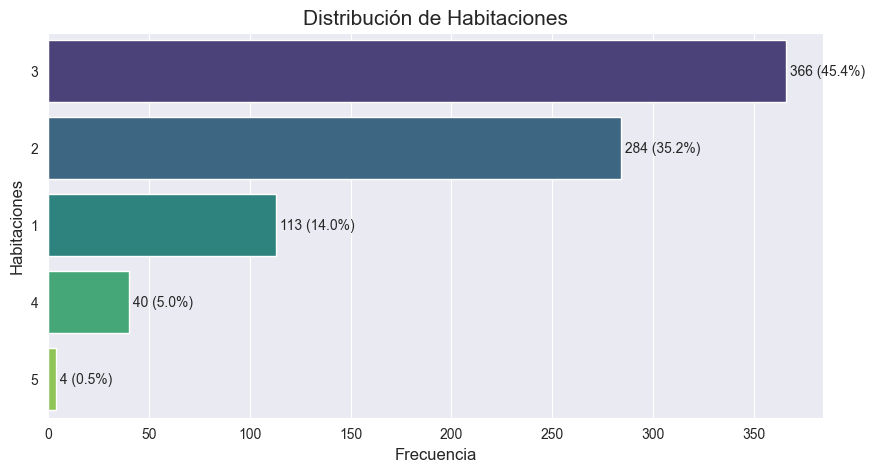

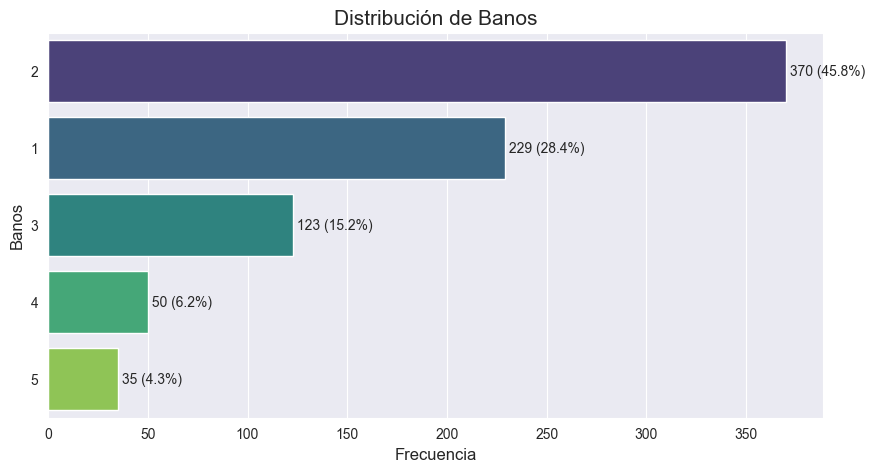

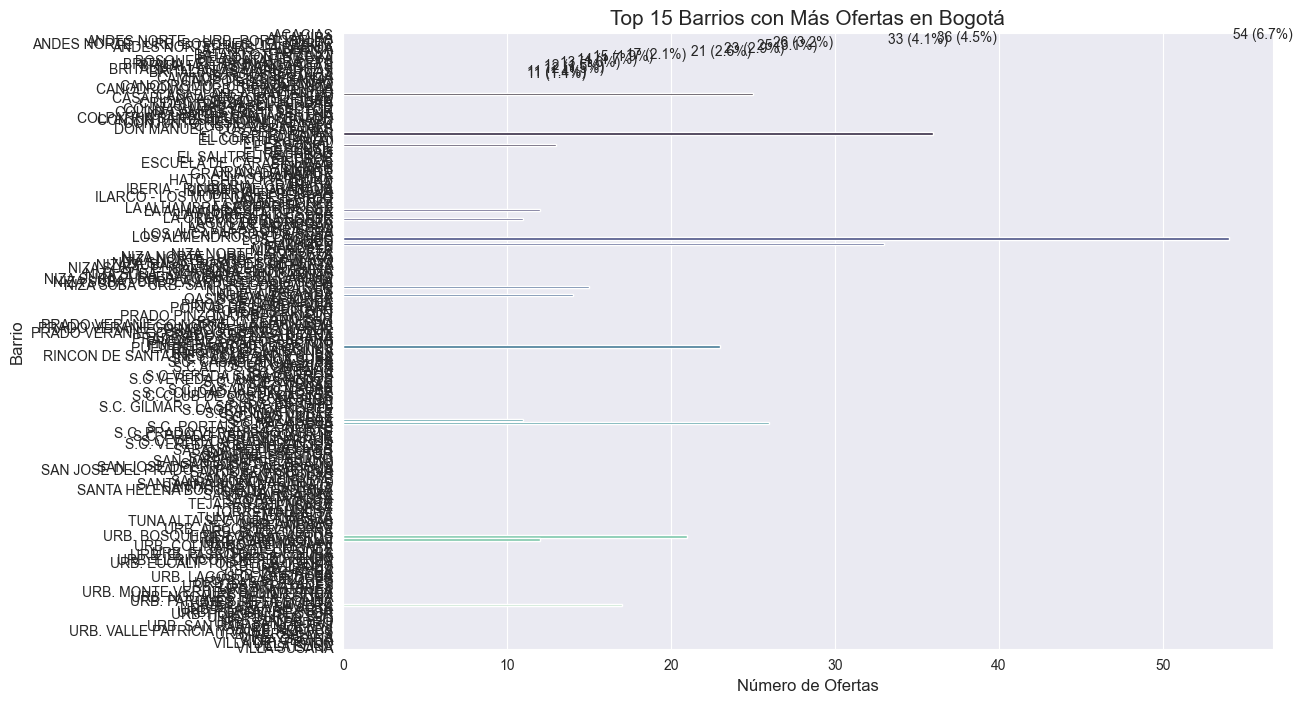

In [144]:
if not df_arriendos.empty:
    cols_to_plot_counts = ['estrato', 'tipo_inmueble', 'habitaciones', 'banos'] # Ajusta a tus columnas

    for col in cols_to_plot_counts:
        if col in df_arriendos.columns:
            plt.figure(figsize=(10, 5))
            # Ordenar por frecuencia para mejor visualización
            order = df_arriendos[col].value_counts().index
            sns.countplot(data=df_arriendos, y=col, order=order, palette='viridis') # 'y' para barras horizontales
            plt.title(f'Distribución de {col.replace("_", " ").capitalize()}', fontsize=15)
            plt.xlabel('Frecuencia', fontsize=12)
            plt.ylabel(col.replace("_", " ").capitalize(), fontsize=12)
            # Añadir conteos en las barras
            for index, value in enumerate(df_arriendos[col].value_counts(ascending=False)): # Ojo si el orden no coincide
                plt.text(value, index, f' {value} ({value/len(df_arriendos)*100:.1f}%)', va='center')
            plt.show()

    # Para barrios (mostrar Top N)
    if 'barrio' in df_arriendos.columns:
        N_TOP_BARRIOS = 15
        plt.figure(figsize=(12, 8))
        # Mostrar los 5 barrios con más ofertas de toda la ciudad
        barrio_counts = df_arriendos['barrio'].value_counts().nlargest(N_TOP_BARRIOS)
        sns.barplot(x=barrio_counts.values, y=barrio_counts.index, palette='mako')
        plt.title(f'Top {N_TOP_BARRIOS} Barrios con Más Ofertas en Bogotá', fontsize=15)
        plt.xlabel('Número de Ofertas', fontsize=12)
        plt.ylabel('Barrio', fontsize=12)
        for index, value in enumerate(barrio_counts):
            plt.text(value, index, f' {value} ({value/len(df_arriendos)*100:.1f}%)', va='center')
        plt.show()
else:
    print("No hay datos de arriendos para analizar variables categóricas.")

## 6. Análisis Exploratorio de Datos (EDA) - Bivariado y Multivariado

Exploraremos las relaciones entre pares de variables y múltiples variables simultáneamente.

### 6.1. Precio vs. Características Numéricas

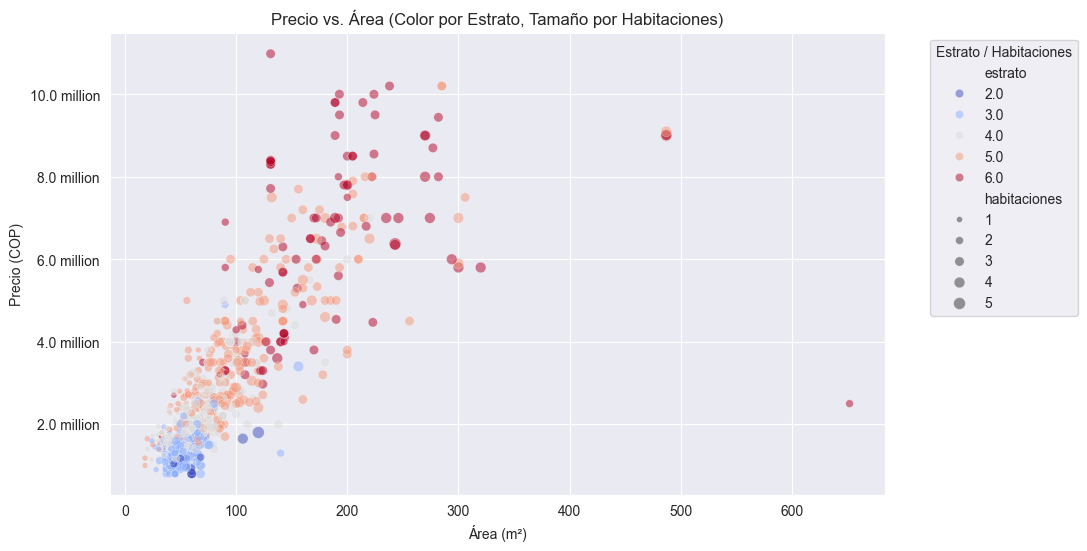

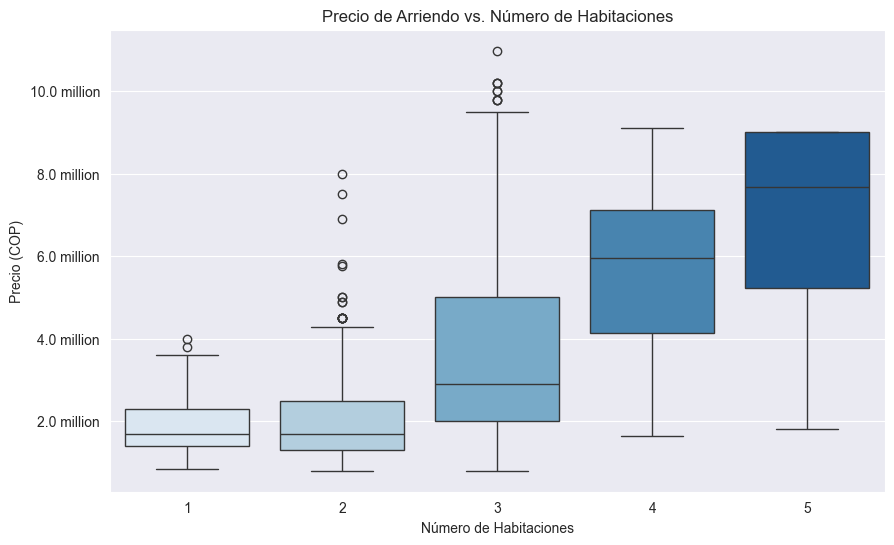

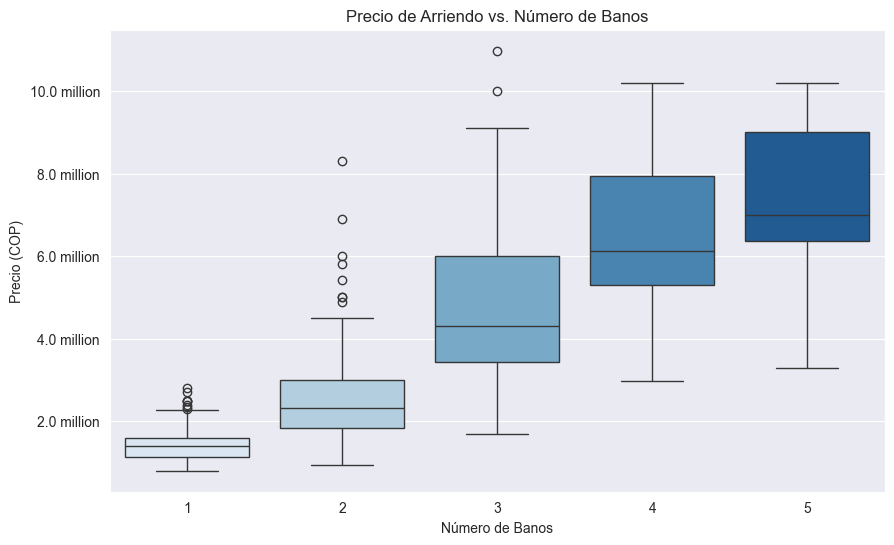

In [145]:
if not df_arriendos.empty and 'precio_arriendo' in df_arriendos.columns:
    # Precio vs Área
    if 'area' in df_arriendos.columns:
        plt.figure(figsize=(10, 6))
        # Usar una muestra si hay demasiados puntos para scatterplot
        sample_df = df_arriendos.sample(min(len(df_arriendos), 2000)) if len(df_arriendos) > 2000 else df_arriendos
        sns.scatterplot(x='area', y='precio_arriendo', data=sample_df, alpha=0.5, hue='estrato', palette='coolwarm', size='habitaciones') # Ejemplo multivariado
        plt.title('Precio vs. Área (Color por Estrato, Tamaño por Habitaciones)')
        plt.xlabel('Área (m²)')
        plt.ylabel('Precio (COP)')
        plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(format_tick_humanize))
        plt.legend(title='Estrato / Habitaciones', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()

    # Considerar boxplots para ver precio vs variables discretas como habitaciones o baños
    for col_discrete in ['habitaciones', 'banos']:
        if col_discrete in df_arriendos.columns:
            plt.figure(figsize=(10, 6))
            # Ordenar categorías para mejor visualización (ej, habitaciones de menor a mayor)
            order = sorted(df_arriendos[col_discrete].dropna().unique())
            sns.boxplot(x=col_discrete, y='precio_arriendo', data=df_arriendos, order=order, palette='Blues')
            plt.title(f'Precio de Arriendo vs. Número de {col_discrete.capitalize()}')
            plt.xlabel(f'Número de {col_discrete.capitalize()}')
            plt.ylabel('Precio (COP)')
            plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(format_tick_humanize))
            plt.show()
else:
    print("Datos de 'precio' o características numéricas no disponibles.")

### 6.2. Precio vs. Características Categóricas

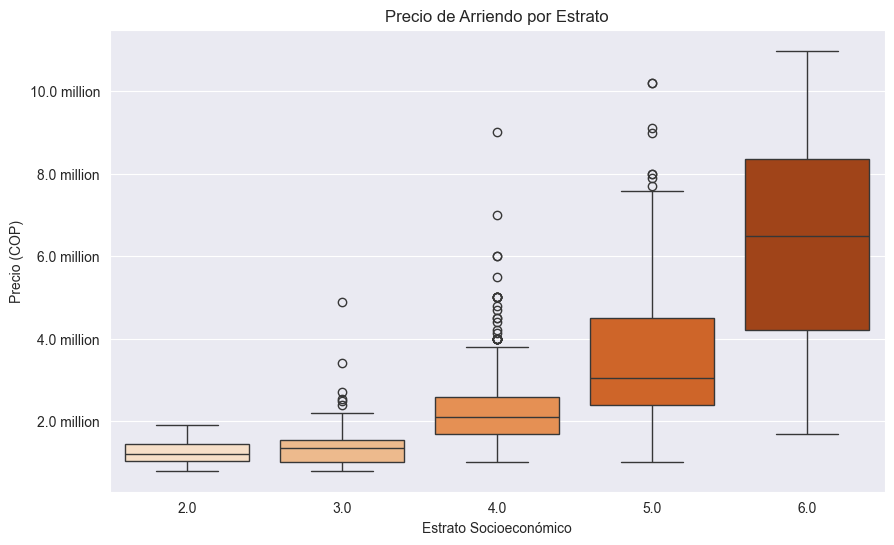

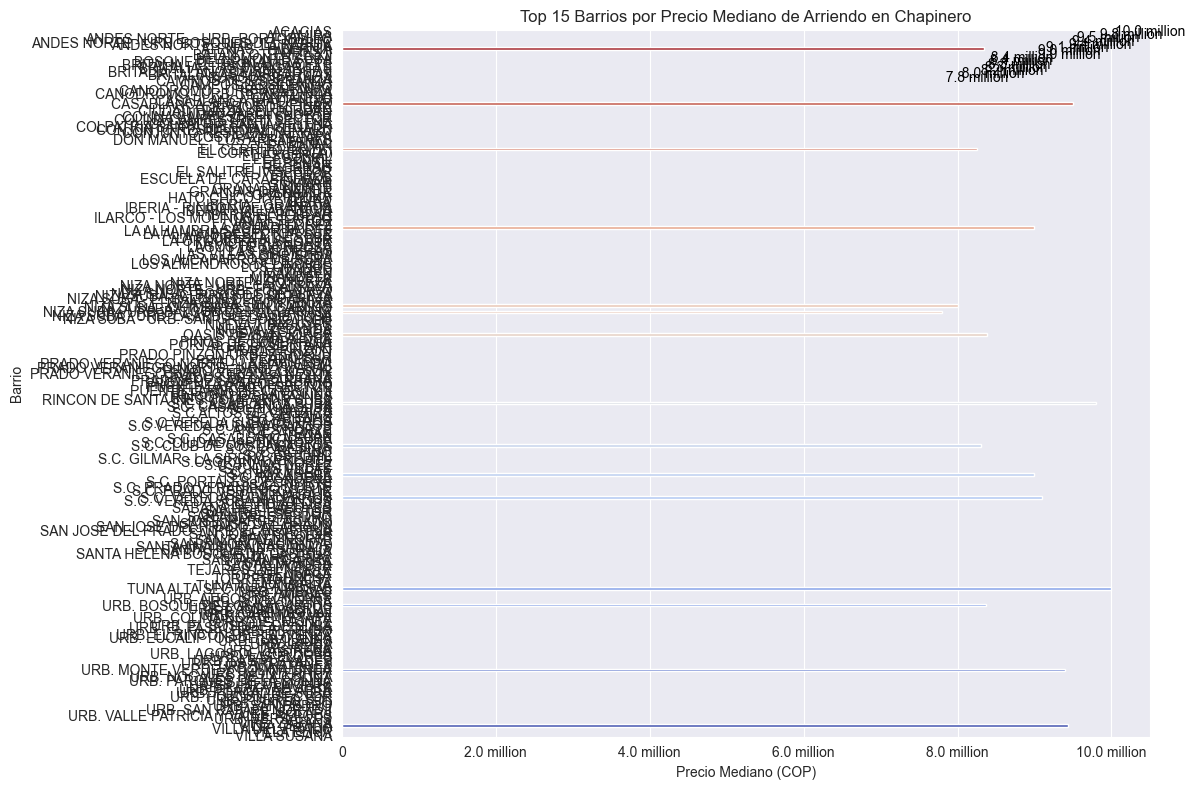

In [146]:
if not df_arriendos.empty and 'precio_arriendo' in df_arriendos.columns:
    # Precio vs Estrato
    if 'estrato' in df_arriendos.columns:
        plt.figure(figsize=(10, 6))
        order_estrato = sorted(df_arriendos['estrato'].dropna().unique())
        sns.boxplot(x='estrato', y='precio_arriendo', data=df_arriendos, order=order_estrato, palette='Oranges')
        plt.title('Precio de Arriendo por Estrato')
        plt.xlabel('Estrato Socioeconómico')
        plt.ylabel('Precio (COP)')
        plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(format_tick_humanize))
        plt.show()

    # Precio vs Tipo de Inmueble
    if 'tipo_inmueble' in df_arriendos.columns:
        plt.figure(figsize=(12, 7))
        # Calcular el precio mediano por tipo de inmueble y ordenar
        median_price_by_type = df_arriendos.groupby('tipo_inmueble')['precio_arriendo'].median().sort_values(ascending=False)
        sns.boxplot(x='tipo_inmueble', y='precio_arriendo', data=df_arriendos, order=median_price_by_type.index, palette='Greens')
        plt.title('Precio de Arriendo por Tipo de Inmueble')
        plt.xlabel('Tipo de Inmueble')
        plt.ylabel('Precio (COP)')
        plt.xticks(rotation=45, ha='right')
        plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(format_tick_humanize))
        plt.tight_layout()
        plt.show()

    # Precio promedio por Barrio (Top N)
    if 'barrio' in df_arriendos.columns:
        N_TOP_BARRIOS_PRECIO = 15
        # Calcular precio mediano por barrio (más robusto a outliers que la media)
        precio_mediano_barrio = df_arriendos.groupby('barrio')['precio_arriendo'].median().dropna().sort_values(ascending=False)

        plt.figure(figsize=(12, 8))
        top_barrios_precio = precio_mediano_barrio.head(N_TOP_BARRIOS_PRECIO)
        sns.barplot(x=top_barrios_precio.values, y=top_barrios_precio.index, palette='coolwarm_r')
        plt.title(f'Top {N_TOP_BARRIOS_PRECIO} Barrios por Precio Mediano de Arriendo en Chapinero')
        plt.xlabel('Precio Mediano (COP)')
        plt.ylabel('Barrio')
        plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_tick_humanize))
        # Añadir valores
        for i, v in enumerate(top_barrios_precio.values):
            plt.text(v, i, f" {format_tick_humanize(v, None)}", color='black', va='center')
        plt.tight_layout()
        plt.show()
else:
    print("Datos de 'precio' o características categóricas no disponibles.")

### 6.3. Matriz de Correlación entre Variables Numéricas

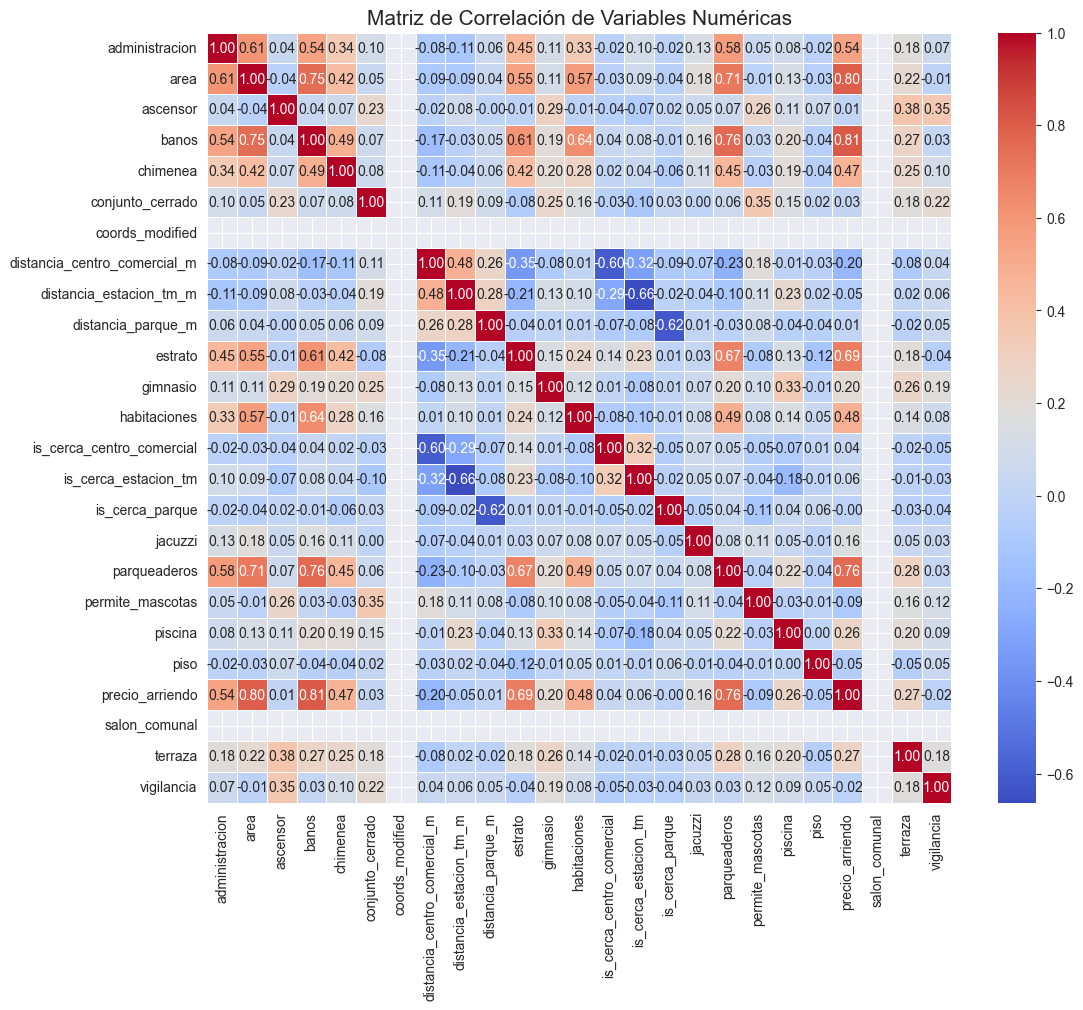

In [147]:
if not df_arriendos.empty:
    # Seleccionar solo columnas numéricas para la correlación
    df_numeric = df_arriendos.select_dtypes(include=np.number)
    # Excluir coordenadas si no son relevantes para esta correlación directa con precio
    cols_to_exclude_corr = ['latitud', 'longitud'] # Añade otras si es necesario
    df_numeric_corr = df_numeric.drop(columns=[col for col in cols_to_exclude_corr if col in df_numeric.columns], errors='ignore')


    if not df_numeric_corr.empty:
        correlation_matrix = df_numeric_corr.corr()
        plt.figure(figsize=(12, 10))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
        plt.title('Matriz de Correlación de Variables Numéricas', fontsize=15)
        plt.show()
    else:
        print("No hay suficientes variables numéricas para calcular la correlación.")
else:
    print("DataFrame de arriendos vacío.")

## 7. Análisis Geoespacial

Visualizaremos la distribución geográfica de los arriendos y los parques, y exploraremos posibles relaciones espaciales.
Asegúrate que `MAPBOX_TOKEN` esté correctamente configurado en tu archivo `.env`.

### 7.1. Distribución Geográfica de los Inmuebles en Arriendo
*(Requiere columnas de `latitud` y `longitud` en `df_arriendos`)*

In [148]:
if not df_arriendos.empty and 'latitud' in df_arriendos.columns and 'longitud' in df_arriendos.columns and MAPBOX_TOKEN:
    # Filtrar outliers de coordenadas si es necesario (ej. fuera de Bogotá)
    # df_geo = df_arriendos[df_arriendos['latitud'].between(4.4, 4.8) & df_arriendos['longitud'].between(-74.2, -73.9)].copy()
    df_geo = df_arriendos.dropna(subset=['latitud', 'longitud', 'precio_arriendo']) # Asegurarse que no hay nulos en estas
    
    # Para mejor visualización, podemos usar una muestra o agregar los datos
    sample_geo_df = df_geo.sample(min(len(df_geo), 5000)) if len(df_geo) > 5000 else df_geo

    fig_arriendos_map = px.scatter_mapbox(
        sample_geo_df,
        lat="latitud",
        lon="longitud",
        color="precio_arriendo",  # Colorear por precio
        size="area",     # Tamaño del punto por área (opcional, puede saturar)
        color_continuous_scale=px.colors.cyclical.IceFire, # O 'Viridis', 'Plasma'
        size_max=15,
        zoom=12, # Ajusta el zoom para Chapinero
        center=dict(lat=4.656, lon=-74.059), # Centro aproximado de Chapinero
        hover_name="barrio", # Lo que aparece al pasar el mouse (si tienes una columna 'id_inmueble' o similar, úsala)
        hover_data={"precio_arriendo": ":,.0f", "area": ":.0f", "estrato": True, "tipo_propiedad": True, "latitud": False, "longitud": False},
        title="Distribución de Arriendos en Chapinero (Color por Precio, Tamaño por Área)"
    )

    fig_arriendos_map.update_layout(
        mapbox_style="dark", # o 'open-street-map', 'carto-positron'
        mapbox_accesstoken=MAPBOX_TOKEN,
        margin={"r":0,"t":40,"l":0,"b":0},
        coloraxis_colorbar_title_text = 'Precio (COP)', # Título para la barra de color
        coloraxis_colorbar_tickformat = ',.0s', # Formato humanize para la barra (K, M)
        # width=1800,  # Aumentar el ancho del mapa
        # height=1200  # Aumentar el alto del mapa
    )
    fig_arriendos_map.show()
elif not MAPBOX_TOKEN:
    print("MAPBOX_TOKEN no disponible. No se puede generar el mapa de arriendos.")
else:
    print("Columnas 'latitud', 'longitud' o 'precio_arriendo' no disponibles en df_arriendos o DataFrame vacío.")

### 7.2. Ubicación de Parques en Chapinero
*(Usa tu código existente para el mapa de parques, con posibles mejoras como título y ajuste de marcadores)*

In [149]:
if not df_parques.empty and 'latitud_parque' in df_parques.columns and 'longitud_parque' in df_parques.columns and MAPBOX_TOKEN:
    # Renombrar columnas si usaste los nombres originales del snippet
    # parques_map_df = df_parques.rename(columns={'LATITUD': 'latitud_parque', 'LONGITUD': 'longitud_parque',
    #                                           'NOMBRE DEL PARQUE O ESCENARIO': 'nombre_parque', 'TIPO DE PARQUE': 'tipo_parque'})
    parques_map_df = df_parques # Si ya renombraste antes

    fig_parques_map = go.Figure()

    fig_parques_map.add_trace(
        go.Scattermapbox(
            lat=parques_map_df['latitud_parque'],
            lon=parques_map_df['longitud_parque'],
            mode='markers',
            name='Parques', # Nombre para la leyenda
            marker=go.scattermapbox.Marker(
                size=10, # Ajusta según la densidad
                color='green',
                opacity=0.7, # Añadir opacidad para ver superposiciones
                allowoverlap=True, # Considera False o clustering si hay muchos
            ),
            # Concatena las columnas que quieras en el hovertext
            text=parques_map_df['nombre_parque'] + ' (' + parques_map_df['tipo_parque'] + ')',
            hoverinfo='text', # Solo muestra el texto que definiste
            hovertemplate='<b>Parque:</b> %{text}<extra></extra>', # <extra></extra> quita la información del trace
            showlegend=True
        )
    )

    fig_parques_map.update_layout(
        title_text='Ubicación de Parques en Chapinero', # Título del mapa
        title_x=0.5, # Centrar título
        mapbox=dict(
            accesstoken=MAPBOX_TOKEN,
            center=dict(lat=4.656, lon=-74.059), # Centro aproximado de Chapinero
            zoom=12, # Ajusta el zoom
            style='dark', # o 'open-street-map', 'carto-positron', 'light'
        ),
        margin=dict(l=0, r=0, t=40, b=0), # Margen superior para el título
        legend=dict(
            yanchor='top',
            y=0.99,
            xanchor='left',
            x=0.01
        )
    )
    fig_parques_map.show()
elif not MAPBOX_TOKEN:
    print("MAPBOX_TOKEN no disponible. No se puede generar el mapa de parques.")
else:
    print("Columnas de coordenadas o nombre no disponibles en df_parques o DataFrame vacío.")

### 7.3. Mapa Combinado: Arriendos y Parques (Opcional)

Superponer arriendos y parques puede ayudar a visualizar proximidades.

In [150]:
if not df_arriendos.empty and 'latitud' in df_arriendos.columns and \
   not df_parques.empty and 'latitud_parque' in df_parques.columns and MAPBOX_TOKEN:

    # Usar la muestra de arriendos del mapa anterior para no saturar
    # sample_geo_df (del mapa de arriendos)
    # parques_map_df (del mapa de parques)

    fig_combined = go.Figure()

    # Trace para Arriendos (puntos más pequeños o con más transparencia)
    fig_combined.add_trace(
        go.Scattermapbox(
            lat=sample_geo_df['latitud'],
            lon=sample_geo_df['longitud'],
            mode='markers',
            name='Arriendos',
            marker=go.scattermapbox.Marker(
                size=5, # Más pequeños
                color=sample_geo_df['precio_arriendo'], # Colorear por precio_arriendo
                colorscale=px.colors.cyclical.IceFire, # Misma escala que antes
                opacity=0.6,
                showscale=True, # Mostrar barra de color para precios
                colorbar=dict(title="Precio Arriendo", tickformat=',.0s')
            ),
            text=sample_geo_df['barrio'].astype(str) + ' - Precio: ' + sample_geo_df['precio_arriendo'].apply(lambda x: format_tick_humanize(x,None)),
            hoverinfo='text',
            showlegend=True
        )
    )

    # Trace para Parques (como en el mapa de parques)
    fig_combined.add_trace(
        go.Scattermapbox(
            lat=parques_map_df['latitud_parque'],
            lon=parques_map_df['longitud_parque'],
            mode='markers',
            name='Parques',
            marker=go.scattermapbox.Marker(
                size=10,
                color='limegreen', # Un verde diferente para distinguir
                opacity=0.8,
            ),
            text=parques_map_df['nombre_parque'],
            hoverinfo='text',
            showlegend=True
        )
    )

    fig_combined.update_layout(
        title_text='Arriendos y Parques en Chapinero',
        title_x=0.5,
        mapbox=dict(
            accesstoken=MAPBOX_TOKEN,
            center=dict(lat=4.656, lon=-74.059),
            zoom=12,
            style='light', # Un estilo claro puede funcionar mejor para capas múltiples
        ),
        margin=dict(l=0, r=0, t=40, b=0),
        legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01)
    )
    fig_combined.show()
else:
    print("Datos o MAPBOX_TOKEN no disponibles para el mapa combinado.")

### 7.4. Análisis de Proximidad a Parques (Avanzado - Opcional)

Si deseamos cuantificar la relación, podríamos calcular la distancia de cada inmueble al parque más cercano. Esto requiere `geopy` o cálculos Haversine.

**Concepto:**
1. Para cada inmueble, iterar sobre todos los parques.
2. Calcular la distancia (ej. Haversine) entre el inmueble y cada parque.
3. Guardar la distancia al parque más cercano.
4. Analizar la correlación o visualización de `precio` vs. `distancia_parque_cercano`.

Calculando distancia al parque más cercano para una muestra de 807 inmuebles...

Primeras filas con la distancia al parque más cercano:


,precio_arriendo,barrio,latitud,longitud,distancia_parque_km
16609,1100000.0,URB. EL BOSQUE DE SUBA,4.736535,-74.089460,0.463942
12214,1200000.0,MAZUREN,4.735447,-74.053055,0.037770
11525,1400000.0,PRADO PINZON,4.727625,-74.053920,0.156193
12679,5300000.0,LAS PALMERAS,4.726401,-74.075220,1.379197
14844,3300000.0,S.C. NIZA SUBA,4.719509,-74.076410,0.641032


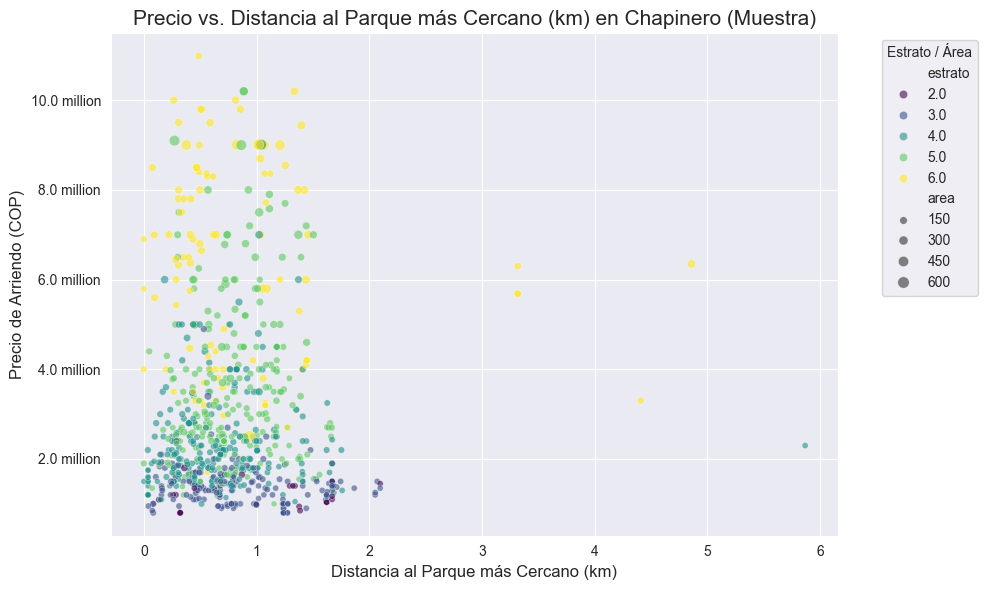


Correlación entre distancia al parque y precio (muestra): 0.01
La correlación es débil, sugiriendo poca relación lineal directa en esta muestra.


In [151]:
# CELDA DE CÓDIGO: Cálculo de Distancia al Parque Más Cercano

from geopy.distance import geodesic
import numpy as np # Asegúrate que numpy esté importado

# Verificar que los DataFrames no estén vacíos y tengan las columnas necesarias
if not df_arriendos.empty and 'latitud' in df_arriendos.columns and 'longitud' in df_arriendos.columns and \
   not df_parques.empty and 'latitud_parque' in df_parques.columns and 'longitud_parque' in df_parques.columns:

    # 1. Preparar DataFrame de parques con coordenadas válidas
    # Seleccionamos solo las columnas necesarias y eliminamos filas donde las coordenadas son nulas
    df_parques_geo = df_parques[['nombre_parque', 'latitud_parque', 'longitud_parque']].copy()
    df_parques_geo.dropna(subset=['latitud_parque', 'longitud_parque'], inplace=True)

    if df_parques_geo.empty:
        print("No hay datos de parques con coordenadas válidas para calcular distancias.")
    else:
        # 2. Definir la función para encontrar la distancia al parque más cercano
        def find_nearest_park_distance(row_arriendo, df_parques_validos):
            """
            Calcula la distancia en km desde un inmueble (fila de df_arriendos)
            al parque más cercano en df_parques_validos.
            """
            try:
                arriendo_coords = (row_arriendo['latitud'], row_arriendo['longitud'])
                # Verificar que las coordenadas del arriendo sean válidas (no NaN)
                if pd.isna(arriendo_coords[0]) or pd.isna(arriendo_coords[1]):
                    return np.nan
            except KeyError: # Si 'latitud' o 'longitud' no existen en la fila
                return np.nan

            min_dist_km = float('inf')

            for _, row_parque in df_parques_validos.iterrows():
                parque_coords = (row_parque['latitud_parque'], row_parque['longitud_parque'])
                try:
                    dist = geodesic(arriendo_coords, parque_coords).km
                    if dist < min_dist_km:
                        min_dist_km = dist
                except ValueError: # En caso de coordenadas inválidas en geopy
                    continue # Saltar este parque y continuar con el siguiente
            
            return min_dist_km if min_dist_km != float('inf') else np.nan

        # 3. Aplicar la función
        # Para demostración y evitar tiempos de ejecución largos, usamos una muestra
        # Si tu df_arriendos es pequeño (< 1000 filas), puedes aplicar a todo el DataFrame
        SAMPLE_SIZE = min(len(df_arriendos), 1000) # Tomar una muestra de máximo 1000 o el total si es menor
        print(f"Calculando distancia al parque más cercano para una muestra de {SAMPLE_SIZE} inmuebles...")
        
        # Asegurarse de que las coordenadas de la muestra de arriendos no sean NaN
        df_arriendos_sample_dist = df_arriendos.dropna(subset=['latitud', 'longitud']).sample(n=SAMPLE_SIZE, random_state=42).copy()

        if not df_arriendos_sample_dist.empty:
            df_arriendos_sample_dist['distancia_parque_km'] = df_arriendos_sample_dist.apply(
                lambda row: find_nearest_park_distance(row, df_parques_geo), axis=1
            )
            
            print("\nPrimeras filas con la distancia al parque más cercano:")
            display(df_arriendos_sample_dist[['precio_arriendo', 'barrio', 'latitud', 'longitud', 'distancia_parque_km']].head())

            # 4. Visualizar la relación entre precio y distancia al parque
            plt.figure(figsize=(10, 6))
            # Filtrar NaNs en distancia_parque_km y precio para el plot
            plot_data = df_arriendos_sample_dist.dropna(subset=['precio_arriendo', 'distancia_parque_km'])
            
            if not plot_data.empty:
                sns.scatterplot(x='distancia_parque_km', y='precio_arriendo', data=plot_data, alpha=0.6, hue='estrato', size='area', palette='viridis')
                plt.title('Precio vs. Distancia al Parque más Cercano (km) en Chapinero (Muestra)', fontsize=15)
                plt.xlabel('Distancia al Parque más Cercano (km)', fontsize=12)
                plt.ylabel('Precio de Arriendo (COP)', fontsize=12)
                plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(format_tick_humanize)) # Usando tu función de formateo
                plt.legend(title='Estrato / Área', bbox_to_anchor=(1.05, 1), loc='upper left')
                plt.grid(True)
                plt.tight_layout()
                plt.show()
                
                # Correlación (opcional)
                if len(plot_data['distancia_parque_km']) > 1 and len(plot_data['precio_arriendo']) > 1: # Se necesita al menos 2 puntos para correlación
                    correlation = plot_data['distancia_parque_km'].corr(plot_data['precio_arriendo'])
                    print(f"\nCorrelación entre distancia al parque y precio (muestra): {correlation:.2f}")
                    if correlation is not np.nan:
                         if correlation < -0.2:
                            print("Se observa una correlación negativa: a menor distancia del parque, mayor podría ser el precio.")
                         elif correlation > 0.2:
                            print("Se observa una correlación positiva: a mayor distancia del parque, mayor podría ser el precio (inesperado, revisar datos).")
                         else:
                            print("La correlación es débil, sugiriendo poca relación lineal directa en esta muestra.")
            else:
                print("No hay datos suficientes para graficar después de filtrar NaNs en precio o distancia.")
        else:
            print("La muestra de arriendos con coordenadas válidas está vacía.")
else:
    print("Datos de arriendos o parques no disponibles, o faltan columnas de coordenadas ('latitud'/'longitud' para arriendos, 'latitud_parque'/'longitud_parque' para parques).")